In [ ]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.models import Model
from keras.optimizers import Optimizer

from keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# import sys
import matplotlib.dates as mdates
import datetime as dt
import time
import h5py
import keras.backend as K
from keras.models import load_model
import tensorflow as tf
from keras.constraints import min_max_norm
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
session = K.tf.Session(config=config)

Using TensorFlow backend.


In [ ]:
def init_weights(time_test):
    weights = []
    for i in range(10):
        weights.append(numpy.loadtxt('arrays/params_'+str(time_test)+'_'+str(i)+'.txt.npy'))
    return weights


# data preparation and normalization
features = ['Close', 'Open', 'High', 'Low', 'Volume']
day_ahead = 1
window_size = 22
train_size = 3100

dataset = pandas.read_csv('data_new/DowJones2.csv')[features]
indexes = dataset.index.values[::-1]
dataset.loc[indexes[0]] = [max(dataset[a]) * 2 for a in features]

def create_dataset(dataset, look_back=1, train_size=50, day_ahead=1):
    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(dataset) - look_back - day_ahead):
        x = dataset[i:(i+look_back):day_ahead, :]
        if i < train_size:
            trainX.append(x)
            trainY.append(numpy.array([dataset[i+look_back-1+day_ahead, features.index('Close')]]))
        else:
            testX.append(x)
            testY.append(numpy.array([dataset[i+look_back-1+day_ahead, features.index('Close')]]))
    return numpy.array(trainX), numpy.array(trainY), numpy.array(testX), numpy.array(testY)

test_size = len(dataset) - train_size
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset = dataset[:-1]
train_x, train_y, test_x, test_y = create_dataset(dataset, window_size*day_ahead, train_size, day_ahead)

def evaluate_test(x, y):
    p = model.predict(x)
    todays = x[:,-1, 0]
    trend_p = [int(numpy.sign(a - b)) for a,b in zip(p.reshape(-1), todays)]
    trend_r = [int(numpy.sign(a - b)) for a,b in zip(y.reshape(-1), todays)]
    trend = [1 if a == b else 0 for a, b in zip(trend_p, trend_r)]
    return 100*numpy.mean(trend)

model = Sequential()
model.add(LSTM(32, 
              input_shape=(window_size, len(features)), 
              return_sequences=True, 
              kernel_initializer='random_normal', 
              bias_initializer='random_normal'))
model.add(LSTM(32, 
              return_sequences=False, 
              kernel_initializer='random_normal',
              bias_initializer='random_normal', 
              input_shape=(window_size, len(features))))
model.add(Dense(22, 
                activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

for i in range(1000):
    hist = model.fit(train_x, train_y, epochs=1, batch_size=200, verbose=0)
    print(i, hist.history, evaluate_test(test_x, test_y))


0 {'loss': [0.024759893936495626]} 37.7483443709
1 {'loss': [0.004915768671179971]} 37.7483443709
2 {'loss': [0.0034593397736429206]} 37.7483443709
3 {'loss': [0.0013853837876775933]} 37.7483443709
4 {'loss': [0.00024707259369953987]} 37.7483443709
5 {'loss': [0.00014646108508215196]} 37.7483443709
6 {'loss': [0.00011206845491899238]} 41.059602649
7 {'loss': [9.5123637771804732e-05]} 41.059602649
8 {'loss': [8.278066806885744e-05]} 44.3708609272
9 {'loss': [7.6600110685009693e-05]} 46.357615894
10 {'loss': [7.1019912044697949e-05]} 63.5761589404
11 {'loss': [6.5334586026672754e-05]} 61.5894039735
12 {'loss': [6.0373601304637571e-05]} 47.0198675497
13 {'loss': [5.8477389463786819e-05]} 45.0331125828
14 {'loss': [5.6718435512119601e-05]} 51.6556291391
15 {'loss': [5.2985490436830946e-05]} 56.2913907285
16 {'loss': [5.1489186467557786e-05]} 57.6158940397
17 {'loss': [5.1410865595361458e-05]} 57.6158940397
18 {'loss': [4.9849110397307442e-05]} 58.2781456954
19 {'loss': [4.9428002028200296e

158 {'loss': [2.6527533273404133e-05]} 42.3841059603
159 {'loss': [2.6393203429066608e-05]} 55.6291390728
160 {'loss': [2.7873968475990209e-05]} 49.0066225166
161 {'loss': [2.6128338034933193e-05]} 50.3311258278
162 {'loss': [2.6405267670915854e-05]} 56.2913907285
163 {'loss': [2.7632345952424069e-05]} 52.3178807947
164 {'loss': [2.7480757360594467e-05]} 52.9801324503
165 {'loss': [2.8504880667183428e-05]} 39.7350993377
166 {'loss': [2.8406871464422664e-05]} 52.3178807947
167 {'loss': [2.5875177954965751e-05]} 56.2913907285
168 {'loss': [2.6663481842279586e-05]} 53.642384106
169 {'loss': [2.5627768052565385e-05]} 49.0066225166
170 {'loss': [2.6383599458401271e-05]} 43.0463576159
171 {'loss': [2.5669253039767126e-05]} 52.3178807947
172 {'loss': [2.6082408024399961e-05]} 45.0331125828
173 {'loss': [2.8315599681058479e-05]} 53.642384106
174 {'loss': [2.6951522510986955e-05]} 50.9933774834
175 {'loss': [2.7604887192513074e-05]} 43.7086092715
176 {'loss': [2.6286989703939688e-05]} 44.370860

In [2]:
# features = ['Open', 'High', 'Low', 'Close', 'Volume']
features = ['Close', 'Open', 'High', 'Low', 'Volume']
dataset = pandas.read_csv('data_new/DowJones.csv')[features]

# indexes = dataset.index.values[::-1]
# dataset.loc[indexes[0]] = [max(dataset[a]) * 2 for a in features]

# for f in features:
#     plt.figure(dpi=200)
#     plt.plot(dataset[f], linewidth=.5)
#     plt.show()

def create_dataset(dataset, look_back=1, train_size=50):
    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(dataset) - look_back):
        x = dataset[i:(i+look_back), :]
        if i < train_size:
            trainX.append(x)
            trainY.append(numpy.array([dataset[i+look_back, features.index('Close')]]))
        else:
            testX.append(x)
            testY.append(numpy.array([dataset[i+look_back, features.index('Close')]]))
    return numpy.array(trainX), numpy.array(trainY), numpy.array(testX), numpy.array(testY)
window_size = 22
# train_size = int(len(dataset)*0.8)
# train_size = len(dataset)
train_size=800
test_size = len(dataset) - train_size

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
# dataset = dataset[:-1]

train_x, train_y, test_x, test_y = create_dataset(dataset, window_size, train_size)

In [108]:
# features = ['Open', 'High', 'Low', 'Close', 'Volume']
features = ['Close', 'Open', 'High', 'Low', 'Volume']
dataset = pandas.read_csv('data_new/DowJones.csv')[features]

indexes = dataset.index.values[::-1]
dataset.loc[indexes[0]] = [max(dataset[a]) * 2 for a in features]

def create_dataset(dataset, look_back=1, train_size=50, day_ahead=1):
    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(dataset) - look_back-day_ahead):
        x = dataset[i:(i+look_back):day_ahead, :]
        if i < train_size:
            trainX.append(x)
            trainY.append(numpy.array([dataset[i+look_back-1+day_ahead, features.index('Close')]]))
        else:
            testX.append(x)
            testY.append(numpy.array([dataset[i+look_back-1+day_ahead, features.index('Close')]]))
    return numpy.array(trainX), numpy.array(trainY), numpy.array(testX), numpy.array(testY)
window_size = 110
day_ahead = 5
# train_size = int(len(dataset)*0.8)
# train_size = len(dataset)
train_size=800
test_size = len(dataset) - train_size

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset = dataset[:-1]

train_x, train_y, test_x, test_y = create_dataset(dataset, window_size, train_size, day_ahead)

In [89]:
train_x.shape

(800, 11, 5)

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, 5), return_sequences=True, init="one"))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
# model.add(Dense(8))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.fit(train_x, train_y, epochs=100, batch_size=32)
plt.figure(dpi=200)
plt.plot(train_y, linewidth=.5)
plt.plot(model.predict(train_x), linewidth=.5)
plt.show()

In [ ]:
predicts = []
running_time = []
trend_result = []
models = []
batch_size = 40
size_pred = 20
model = Sequential()
model.add(LSTM(48, input_shape=(window_size, len(features)), return_sequences=True, 
               kernel_initializer='random_normal',
              bias_initializer='random_normal'))
model.add(LSTM(48, return_sequences=False, kernel_initializer='random_normal',
               bias_initializer='random_normal',
               input_shape=(window_size, len(features))))
model.add(Dense(22, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
for i in range(len(test_x)):
    start_time = time.time()
    verbose = 0
    if i%size_pred == 0:
        print(i)
        hist = model.fit(train_x, train_y, epochs=100, batch_size=batch_size, verbose=0)
        print(hist.history['loss'][-1])
        
        predicts.append(model.predict(test_x[i:i+size_pred]).flatten())
        
        ps = model.predict(test_x[i:i+size_pred])
        todays = test_x[i:i+batch_size,-1, 0]
        trend_p = [int(numpy.sign(a - b)) for a,b in zip(ps.reshape(-1,1), todays)]
        # trend_p = [1]*test_y.shape[0]
        trend_r = [int(numpy.sign(a - b)) for a,b in zip(test_y[i:i+size_pred].reshape(-1), todays)]
        trend = [1 if a == b else 0 for a, b in zip(trend_p, trend_r)]
        print(numpy.mean(trend))
        
        running_time.append(time.time() - start_time)
        print('time: ' + str(running_time[-1]))

    train_x = numpy.append(train_x, test_x[i].reshape(1, window_size, len(features)), axis=0)
    train_y = numpy.append(train_y, test_y[i].reshape(1, 1), axis=0)
    
# %store predicts
predicts = numpy.array(predicts).reshape(-1, 1)
ps = []
for a in predicts:
    ps.append(a)
ps = numpy.concatenate(numpy.array(ps).flatten())
ps = ps.reshape(-1, 1)

0
0.000385339571949
0.35
time: 117.99068641662598
20
0.000330603182481
0.45
time: 119.97843551635742
40
0.000321486892062
0.65
time: 111.36373925209045
60
0.000282429815893
0.45
time: 125.01122236251831
80
0.000268062444361
0.4
time: 121.80407094955444
100
0.000238881509803
0.65
time: 132.73735642433167
120
0.000210612659904
0.7
time: 138.29297590255737
140
0.000188370886385
0.5
time: 136.33908867835999
160
0.000175193800108
0.3
time: 142.4223289489746
180


In [ ]:
768+20

In [ ]:
def loss_1(y_true, y_pred):
    nds = tf.concat([y_true[1:], [[1]]], 0)
    
    one = tf.constant(list([-1.0] * 768))
    trend_t = nds - y_true
    trend_p = nds - y_pred
    trend = tf.div(tf.multiply(trend_t, one), trend_p)
    return K.sum(trend, axis=0)

def loss_2(ytrue, ypred):
    nds = tf.concat([ytrue[1:], [[1]]], 0)
    one = tf.constant(list([-1.0] * 768))
    trendt = nds - ytrue
    trendp = nds - ypred
    trend = tf.div(tf.multiply(trendp, one), trendt)
    return K.sum(K.sign(trend), axis=0)+768

def custom_loss(y_true, y_pred):
    y_true.set_shape((None, 1))
    next_days = tf.concat([y_true[1:], [[1]]], 0)
    trend_t = K.sign(next_days - y_true)
    trend_p = K.sign(next_days - y_pred)
    not_correct = K.not_equal(trend_t, trend_p)
    
    return K.mean(K.square(y_pred - y_true), axis=-1) + K.sum(K.cast(not_correct, tf.float32), axis=0)/70000

def mse(ytrue, ypred):
    nds = tf.concat([ytrue[1:], [[1]]], 0)
    one = tf.constant(list([-1.0] * 768))
    trendt = nds - ytrue
    trendp = nds - ypred
#     trend = tf.div(tf.multiply(trendp, one), trendt)
    return K.mean(K.square(ypred - ytrue), axis=-1) + K.categorical_crossentropy(trendt, trendp)

def relu_activation(x):
    return K.relu(x)

weights = []

for i in range(5):
    model = Sequential()
    model.add(LSTM(128, input_shape=(window_size, len(features)), return_sequences=True, 
                   kernel_initializer='random_normal',
                  bias_initializer='random_normal'))
    model.add(LSTM(128, return_sequences=False, kernel_initializer='random_normal',
                   bias_initializer='random_normal',
                   input_shape=(window_size, len(features))))
    model.add(Dense(22, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=15,batch_size=48, verbose=1)
    weights.append({'before': model.get_weights})

    ps = model.predict(test_x)
    todays = test_x[:,-1, 0]
    trend_p = [int(numpy.sign(a - b)) for a,b in zip(ps.reshape(-1,1), todays)]
    # trend_p = [1]*test_y.shape[0]
    trend_r = [int(numpy.sign(a - b)) for a,b in zip(test_y.reshape(-1), todays)]
    trend = [1 if a == b else 0 for a, b in zip(trend_p, trend_r)]
    print(numpy.mean(trend))
    weights[-1]['trend_test'] = trend

    ps = model.predict(train_x)
    todays = train_x[:,-1, 0]
    trend_p = [int(numpy.sign(a - b)) for a,b in zip(ps.reshape(-1,1), todays)]
    # trend_p = [1]*test_y.shape[0]
    trend_r = [int(numpy.sign(a - b)) for a,b in zip(train_y.reshape(-1), todays)]
    trend = [1 if a == b else 0 for a, b in zip(trend_p, trend_r)]
    print(numpy.mean(trend))
    weights[-1]['trend_train'] = trend
    weights[-1]['after'] = model.get_weights()

In [110]:
model = Sequential()
model.add(LSTM(64, input_shape=(int(window_size/day_ahead), len(features)), return_sequences=True, 
               kernel_initializer='random_normal',
              bias_initializer='random_normal', bias_constraint=min_max_norm(min_value=0, max_value=0)))
model.add(LSTM(64, return_sequences=False, kernel_initializer='random_normal',
               bias_initializer='random_normal',
               input_shape=(int(window_size/day_ahead), len(features)), bias_constraint=min_max_norm(min_value=0, max_value=0)))
# model.add(LSTM(64, return_sequences=False, kernel_initializer='random_uniform',
#               bias_initializer='zeros', input_shape=(1, 5)))
model.add(Dense(22, activation='relu', bias_constraint=min_max_norm(min_value=0, max_value=0)))
model.add(Dense(1,bias_constraint=min_max_norm(min_value=0, max_value=0)))
model.compile(loss='mse', optimizer='adam')
model.fit(train_x, train_y, epochs=10,batch_size=2, verbose=1)

Epoch 1/10
800/800 [==============================] - 27s - loss: 0.0010    
Epoch 2/10
800/800 [==============================] - 24s - loss: 2.6471e-04    
Epoch 3/10
800/800 [==============================] - 29s - loss: 2.2624e-04    
Epoch 4/10
800/800 [==============================] - 28s - loss: 1.9023e-04    
Epoch 5/10
800/800 [==============================] - 26s - loss: 1.7073e-04    
Epoch 6/10
800/800 [==============================] - 26s - loss: 1.7185e-04    
Epoch 7/10
800/800 [==============================] - 26s - loss: 1.5725e-04    
Epoch 8/10
800/800 [==============================] - 25s - loss: 1.5517e-04    
Epoch 9/10
800/800 [==============================] - 28s - loss: 1.6381e-04    
Epoch 10/10
800/800 [==============================] - 28s - loss: 1.5376e-04    


11.0

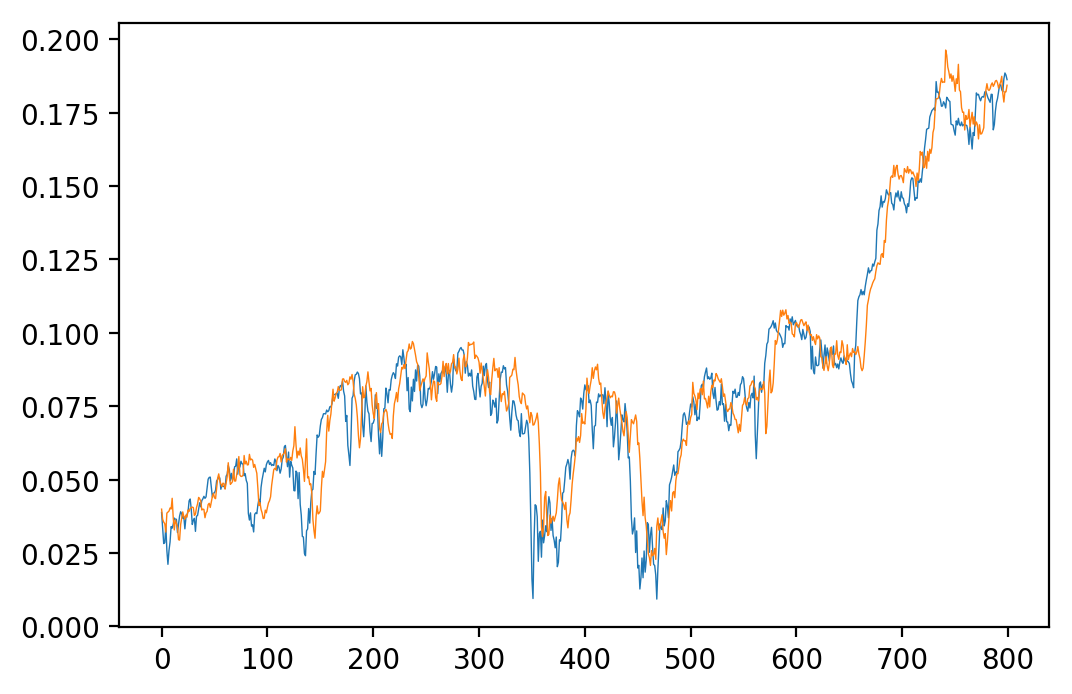

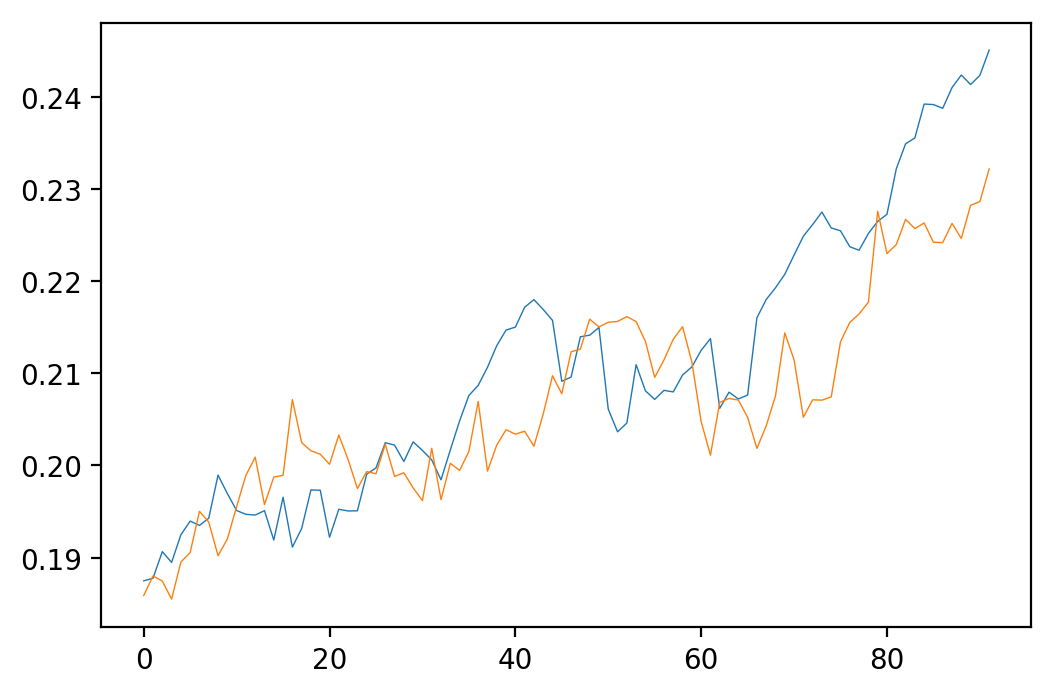

In [111]:
plt.figure(dpi=200)
plt.plot(train_y, linewidth=.5)
plt.plot(model.predict(train_x), linewidth=.5)
plt.show()

plt.figure(dpi=200)
plt.plot(test_y, linewidth=.5)
plt.plot(model.predict(test_x), linewidth=.5)
plt.show()

# plt.figure(dpi=200)
# plt.plot(test_y, linewidth=.5)
# plt.plot(ps, linewidth=.5)
# plt.show()

In [58]:
model.get_weights()

[array([[ 0.09003108,  0.03086692, -0.01439771, ...,  0.05848498,
          0.08166261,  0.05656719],
        [ 0.11313906,  0.03824525, -0.10775397, ...,  0.03617955,
          0.09913253,  0.06393882],
        [ 0.04981897,  0.0839772 ,  0.01062067, ..., -0.01386408,
         -0.01192828,  0.1032142 ],
        [ 0.08288292,  0.00967482, -0.1429013 , ..., -0.10435218,
          0.06899577,  0.12014121],
        [-0.01750688,  0.00557287,  0.04942163, ...,  0.02450618,
          0.14050679,  0.0472354 ]], dtype=float32),
 array([[ 0.04560703,  0.00470499, -0.03327232, ..., -0.19423369,
          0.03644228,  0.04968264],
        [-0.03486316, -0.05023488, -0.03437044, ...,  0.02899881,
          0.00512709,  0.08722831],
        [-0.1357172 ,  0.08824657,  0.04725907, ..., -0.02301211,
          0.08131523, -0.13508816],
        ..., 
        [ 0.06184078,  0.11522115,  0.0844891 , ...,  0.13983391,
          0.03848729, -0.05720503],
        [ 0.03257638, -0.06215336,  0.09907645, ...

In [42]:
abs(ps[:,0] - test_y[:, 0])

array([ 0.00574823,  0.00589783,  0.00450378,  0.00882165,  0.00432648,
        0.00202582,  0.00696359,  0.0118028 ,  0.00794019,  0.0063786 ,
        0.0052482 ,  0.00864842,  0.00254359,  0.00241189,  0.00456193,
        0.00757033,  0.01022759,  0.0065476 ,  0.00716591,  0.00658379,
        0.0015634 ,  0.00270334,  0.00840073,  0.00222694,  0.00549757,
        0.0013665 ,  0.00800728,  0.00382428,  0.00158145,  0.00996676,
        0.00668011,  0.00580929,  0.00191118,  0.00607036,  0.00754391,
        0.00291674,  0.0048453 ,  0.00617776,  0.00399433,  0.00900042,
        0.00076737,  0.00017128,  0.00486398,  0.00110252,  0.00774145,
        0.00642499,  0.00036004,  0.00029587,  0.00546477,  0.00179532,
        0.00504013,  0.00352022,  0.00010192,  0.0035393 ,  0.00065311,
        0.00149513,  0.00145176,  0.00197909,  0.00117313,  0.00235402,
        0.00379889,  0.00245749,  0.00267117,  0.00219901,  0.00292438,
        0.00403107,  0.00041689,  0.00873613,  0.01105981,  0.00

In [112]:
# model.set_weights(t)
ps = model.predict(test_x)
todays = test_x[:,-1, 0]
trend_p = [int(numpy.sign(a - b)) for a,b in zip(ps.reshape(-1), todays)]
# trend_p = [1]*test_y.shape[0]
trend_r = [int(numpy.sign(a - b)) for a,b in zip(test_y.reshape(-1), todays)]
trend = [1 if a == b else 0 for a, b in zip(trend_p, trend_r)]
print(numpy.mean(trend))

ps = model.predict(train_x)
todays = train_x[:,-1, 0]
trend_p = [int(numpy.sign(a - b)) for a,b in zip(ps.reshape(-1,1), todays)]
# trend_p = [1]*test_y.shape[0]
trend_r = [int(numpy.sign(a - b)) for a,b in zip(train_y.reshape(-1), todays)]
trend = [1 if a == b else 0 for a, b in zip(trend_p, trend_r)]
print(numpy.mean(trend))

0.597826086957
0.6025


In [75]:
maxx = 0
corrects = []
for i in range(len(trend)):
    if i%10 != 0:
        continue
    ncorrect = sum(trend[i:i+10])
    corrects.append(ncorrect)
    if ncorrect > maxx:
        maxx = ncorrect
        index = i
print(maxx, index)
print(corrects)

8 60
[3, 5, 2, 6, 3, 3, 8, 4, 6, 6, 5, 4, 5, 5, 6, 4, 5, 3, 4, 5, 4, 4, 5, 3, 2, 7, 5, 1, 5, 4, 6, 4, 6, 7, 6, 7, 7, 3, 3, 7, 5, 5, 4, 5, 5, 8, 6, 2, 6, 5, 7, 5, 8, 5, 7, 5, 6, 5, 3, 7, 4, 5, 5, 6, 3, 6, 4, 2, 6, 4, 4, 7, 7, 5, 1, 4, 7, 4, 5, 3]


In [24]:
for i in range(5):
    ps = numpy.append(ps, numpy.zeros(ps.shape[0]), axis=1)

ValueError: all the input arrays must have same number of dimensions

In [ ]:
for i in t:
    print(numpy.array(i).shape)

In [ ]:
shapes = [(5, 256), (64, 256), (256,), (64, 256), (64, 256), (256,), (64, 22), (22,), (22,1), (1,)]

class Individual():
    def __init__(self):
        self.params = numpy.array([])
    def __init__(self, params, t="normal"):
        if t == "normal":
            self.params = params
        elif t == "model params":
            self.params = self._flatten_model_params(params)
    def init_random(self):
        pass
    def _flatten_model_params(self, model_params):
        raw = numpy.array([])
        for i in model_params:
            raw = numpy.concatenate([raw, i.flatten()], axis=0)
        return raw
    def get_model_params(self):
        raw = []
        index_start = 0
        for x in shapes:
            if len(x) == 1:
                length = x[0]
            elif len(x) == 2:
                length = x[0] * x[1]
            raw.append(numpy.array(self.params[index_start:index_start+length]).reshape(x))
            index_start += length
        return raw
    def calc_mse(self, y_true, y_pred):
        return numpy.mean(abs(y_true - y_pred))
    def calc_up_down_trend(self, prev_days, y_true, y_pred):
        trend_reality = [int(numpy.sign(a-b)) for a, b in zip(y_true, prev_days)]
        trend_predicts = [int(numpy.sign(a-b)) for a, b in zip(y_pred, prev_days)]
        return numpy.mean([1 if a==b else 0 for a,b in zip(trend_reality, trend_predicts)])
    def calc_fitness(self, neural_model, input_x, y_true):
        # test_x: (None, window_size, n_features) | test_y: (None, 1)         
        neural_model.set_weights(self.get_model_params())
        model.compile(loss='mse', optimizer='adam')
        predicts = neural_model.predict(input_x) # (None, 1)
        # calculate MSE
        self.mse = self.calc_mse(y_true.flatten(), predicts.flatten())
        # calculate up down trend
        self.trend = self.calc_up_down_trend(input_x[:,-1,0], y_true.flatten(), predicts.flatten())
        # fitness
        self.fitness = 1/self.mse + self.trend
    def __str__(self):
        return "Individual Fitness: " + str(self.fitness) + " | MSE: " + str(self.mse) + " | UD-Trend: " + str(self.trend)

class GA():
    def __init__(self):
        self.generations = 10
        self.len_params = 0
        self.len_population = 20
        for x in shapes:
            if len(x) == 1:
                self.len_params += x[0]
            else:
                self.len_params += (x[0]*x[1])
        
    def run(self):
        self._init_population(self.len_population)
        self.sort_population()
#         self.print_population()
        for g in range(self.generations):
            print(self.population[0])
            for index_mother in range(self.len_population):
                index_father = numpy.random.randint(self.len_population)
                while index_father == index_mother:
                    index_father = numpy.random.randint(self.len_population)
                mother = self.population[index_mother]
                father = self.population[index_father]

                child1, child2 = self.crossover(mother, father)
                self.mutation(child1)
                self.mutation(child2)
                child1.calc_fitness(model, train_x, train_y)
                child2.calc_fitness(model, train_x, train_y)

                self.population.append(child1)
                self.population.append(child2)
            self.sort_population()
            del self.population[self.len_population:]
        print(self.population[0])
    def _init_population(self, n_inds):
        self.population = []
        for i in range(n_inds):
            global ind
            ind = Individual(self._init_random_params())
            self.population.append(ind)
            ind.calc_fitness(model, train_x, train_y)
    def _init_random_params(self):
        return numpy.random.rand(self.len_params)
    def print_population(self):
        for ind in self.population:
            print(ind)
    def sort_population(self):
        self.population.sort(key=lambda x:x.fitness, reverse=True)
    def crossover(self, ind1, ind2):
        rand_first = numpy.random.randint(50944, self.len_params-1)
        rand_last = numpy.random.randint(rand_first+1, self.len_params+1)
        cross = ind1.params[rand_first:rand_last] + ind2.params[rand_first:rand_last]
#         cross = numpy.array([a/2 for a in cross])
        params1 = numpy.concatenate([ind1.params[:rand_first], cross, ind1.params[rand_last:]], axis=0)
        params2 = numpy.concatenate([ind2.params[:rand_first], cross, ind2.params[rand_last:]], axis=0)
        ind3 = Individual(params1)
        ind4 = Individual(params2)
        return ind3, ind4
    def mutation(self, ind):
        for i in range(len(ind.params)):
            if numpy.random.uniform(100) < 0.5:
                sigma = 3
                x = ind.params[i]
                delta_x = 1/math.sqrt(2*math.pi*sigma**2) * math.exp(-x**2/(2*sigma**2))
                ind.params[i] += delta_x

In [ ]:
g = GA()
g.run()

In [ ]:
a = numpy.zeros(g.len_params)
b = Individual(a)
b.calc_fitness(model, train_x, train_y)
print(b)
c = numpy.concatenate([[1]*50944, [0]*1453], axis=0)
# c = []
# for i in range(1000):
#     c.append(1)
# for i in range(1000, g.len_params):
#     c.append(0)

# c = numpy.ones(g.len_params)
d = Individual(c)
d.calc_fitness(model, train_x, train_y)
print(d)

In [ ]:
model.summary()
3

In [ ]:
ps_trf = ps
ty_trf = test_y
for i in range(1,5):
    ps_trf = numpy.append(ps_trf, numpy.zeros((ps_trf.shape[0], 1)), axis=1)
    ty_trf = numpy.append(ty_trf, numpy.zeros((ty_trf.shape[0], 1)), axis=1)
ps_trf = scaler.inverse_transform(ps_trf)
ty_trf = scaler.inverse_transform(ty_trf)
ps_trf = ps_trf[:,0]
ty_trf = ty_trf[:,0]

In [ ]:
# from sklearn.utils import check_arrays
def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = check_arrays(y_true, y_pred)
    return numpy.mean(numpy.abs((y_true - y_pred) / y_true)) * 100
def mean_absolute_error(y_true, y_pred):
    return numpy.mean(abs(y_true - y_pred))
print(mean_absolute_percentage_error(ty_trf.reshape(-1), ps_trf.reshape(-1)))
print(mean_absolute_error(ty_trf, ps_trf))

In [ ]:
plt.figure(dpi=300)
plt.plot(ty_trf, linewidth=.5)
plt.plot(ps_trf, linewidth=.5)
plt.show()

In [ ]:
predicts = predicts.reshape(predicts.shape[0], 1)

In [ ]:
results = [{
    'name': 'DowJones',
    'number_day_train': 768,
    'number_day_test': 217,
    'number_day_refit': 50,
    'percent_trend': 54.84,
    'mape_test': 0.445,
    'mae_test': 93.917,
    'running_time': 683.69,
    'environment': 'Windows 10 - 4GB RAM - Tensorflow'
}, {
    'name': 'VNIndex',
    'number_day_trains': 768,
    'number_day_test': 207,
    'number_day_refit': 0,
    'percent_trend': 57.97,
    'mape_test': 0.5797,
    'mae_test': 4.2824,
    'running_time': 349,
    'environment': 'Windows 10 - 4GB RAM - Tensorflow'
}
]
# model.save('results/model_dowjones.h5')
# %store predicts_dowjones
model.save('results/model_vnindex.h5')
predicts_vnindex = ps
%store predicts_vnindex

In [ ]:
def custom_activation(x):
    return K.relu(x)
model = load_model('results/model_dowjones.h5')

In [ ]:
predicts_vnindex